In [31]:
import os
import sys
import glob
    
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_available_gpus()

['/device:CPU:0', '/device:GPU:0']

In [4]:
paths_mesh = glob.glob(os.path.join('..', 'data', 'raw', 'ex2', 'mesh', '*.mesh'))
paths_vtu = glob.glob(os.path.join('..', 'data', 'raw', 'ex2', 'vtu', '*.vtu'))

case_names = [path.split(os.path.sep)[-1].replace('.mesh', '') for path in paths_mesh]

paths_mesh = dict(zip(case_names, paths_mesh))
paths_vtu = dict(zip(case_names, paths_vtu))

In [5]:
from trainer.preprocess import PreprocessBatch

In [6]:
preprocessor = PreprocessBatch(is_train=True, path_output='.', feature_name='boundary_surface_edge')

In [7]:
preprocessor.populate(case_names, paths_mesh, paths_vtu)

C:\Users\farig\Documents\PhD\cnn_battery\trainer\util.py:193: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\farig\Documents\PhD\cnn_battery\trainer\util.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  self.soup = BeautifulSoup(mesh)


reading file: (34) Rc_1.0_h_97.3_tac_10.0_tel_19.7


In [11]:
mesh_data_0 = preprocessor.mesh_data[case_names[0]]

In [17]:
mesh_data_0.keys()

dict_keys(['coord', 'groups_node', 'groups_element_nodes', 'element_connect'])

In [104]:
def dist_radial(x):
    return np.exp(-1 * x/(x.max()+1e-8))

In [105]:
embedding = np.zeros(mesh_data_0['coord'].shape)

In [113]:
coords = mesh_data_0['coord']

dists = {}
for name, nodes in mesh_data_0['groups_node'].items():
    coords_some = coords[nodes]
    dist = distance.cdist(coords, coords_some)
    dist = dist_radial(dist)
    dists.update({name: dist})

In [107]:
dists.keys()

dict_keys(['leftEdgeSPE', 'leftEdgeCathode', 'leftEdgeAnode', 'yZero', 'rightEdgeAnode', 'rightEdgeSPE', 'rightEdgeCathode', 'yTop', 'intCatElCathode', 'intCatElSPE', 'intAnElSPE', 'intAnElAnode'])

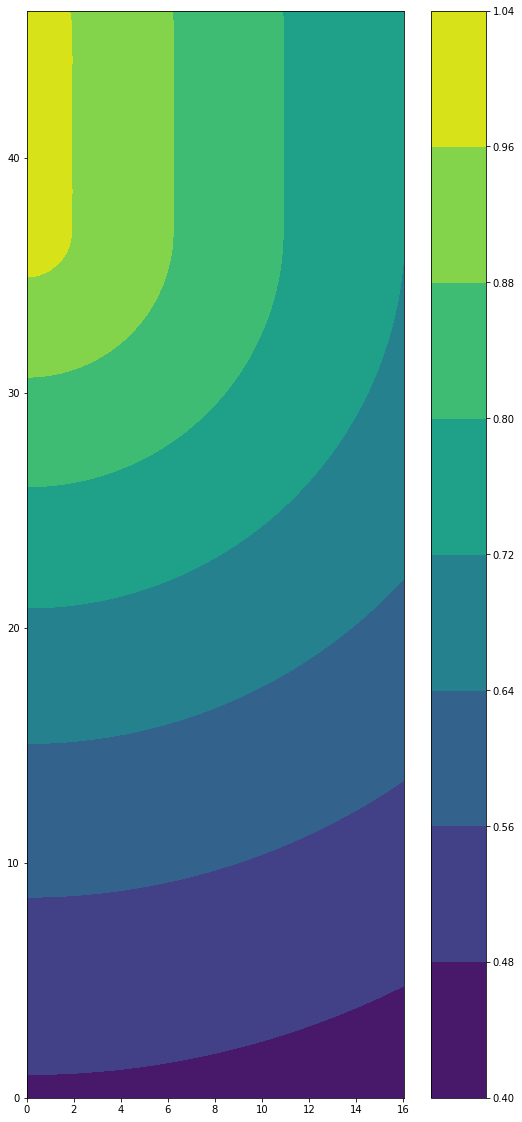

In [156]:
x=coords[:,0] 
y=coords[:,1] 
triangles=list(mesh_data_0['element_connect'].values())
# z=dists['leftEdgeCathode'].min(axis=1)
z = np.mean(np.sort(dists['leftEdgeCathode'], axis=1)[:, -3:], axis=1)

plt.figure(figsize=(10,20))
plt.tricontourf(x, y, triangles, z)
plt.gca().set_aspect('equal')
plt.colorbar()

In [157]:
from scipy import interpolate

In [161]:
# f = interpolate.interp2d(x, y, z, kind='linear')
f = interpolate.NearestNDInterpolator(coords, z)

In [163]:
from collections import namedtuple

GRID_DIM = namedtuple('GRID_DIM', 'x y')(64, 512)

x_y_max = coords.max(axis=0)
x_max = 0
y_max = 0

if x_y_max[0] > x_max:
    x_max = x_y_max[0]

if x_y_max[1] > y_max:
    y_max = x_y_max[1]

                
x_ = np.linspace(0, x_max, GRID_DIM.x, dtype=np.float32)
y_ = np.linspace(0, y_max, GRID_DIM.y, dtype=np.float32)

x_grid, y_grid = np.meshgrid(x_, y_)

In [165]:
z_ = f(x_grid, y_grid)

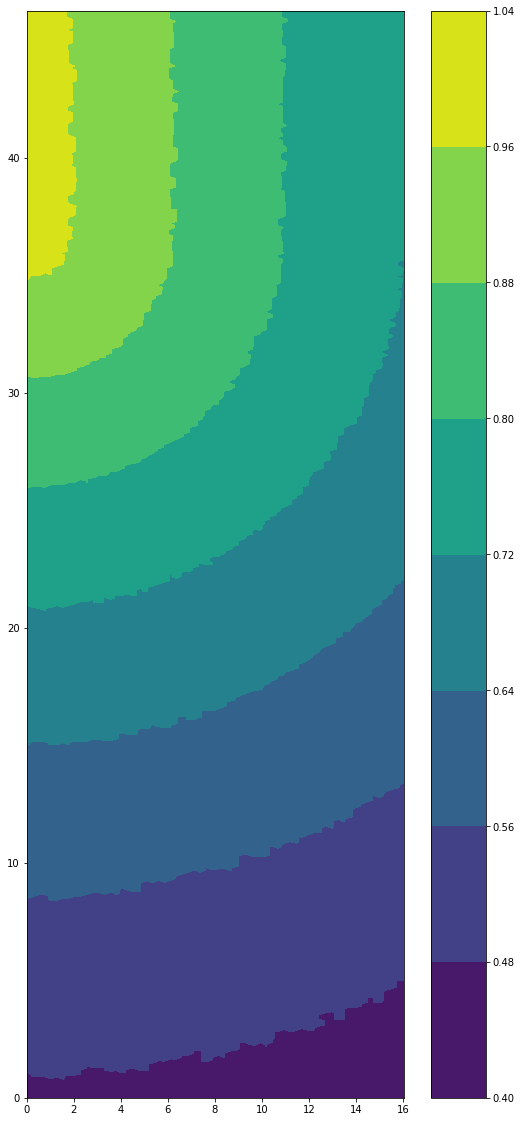

In [168]:
plt.figure(figsize=(10,20))
plt.contourf(x_, y_, z_)
plt.gca().set_aspect('equal')
plt.colorbar()

In [166]:
z_.shape

(512, 64)